

### Description

The dataset used in this notebook reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.
The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. 

The complete feature list in the raw data is as follows:

1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain

We use this data to build a LSTM model and forecast pollution levels.

### Importing Required Packages

In [70]:

import pandas as pd
import numpy as np
import datetime as datetime
from matplotlib import pyplot as plt
from pandas import DataFrame, concat
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

In [71]:
# A simple helper function to analyse dataframe

def analyse_dataframe_info(dataframe):
    print("\nDF info\n")
    print(dataframe.info())

    print("\nHead\n")
    print(dataframe.head(10))

    print("\nShape\n")
    print(dataframe.shape)

    print("\nNull values\n")
    for column_name in dataframe.columns:
        null_values = df[column_name].isna().sum()
        if null_values > 0:
            print("%s has %s null values" % (column_name, null_values))

        

In [72]:
# Load and preprocess the dataset 
file_path = './PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(file_path)
analyse_dataframe_info(df)

# first row is number, we drop it
df.drop('No', axis=1, inplace=True)

# first 24 hrs has NA as pm2.5 data, so we drop them
df = df[24:]

# we find pm2.5 column has 2067 NA values in total including NA for first 24 hrs, we fill them with zero
df['pm2.5'].fillna(0, inplace=True)

# we combine day, month, year, hour into timestamp and use that column as index
df['date'] = df.apply(lambda x : datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
df = df.set_index('date')

# we assign meaningful names to columns
df.columns = ['pollution', 'dew', 'temp', 'press', 'wind_dir', 'wnd_spd', 'snow', 'rain']
#lets check how our dataframe looks now
df.head(10)



DF info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB
None

Head

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1   

,pollution,dew,temp,press,wind_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


###  Data Visualization
Create a quick plot of each series

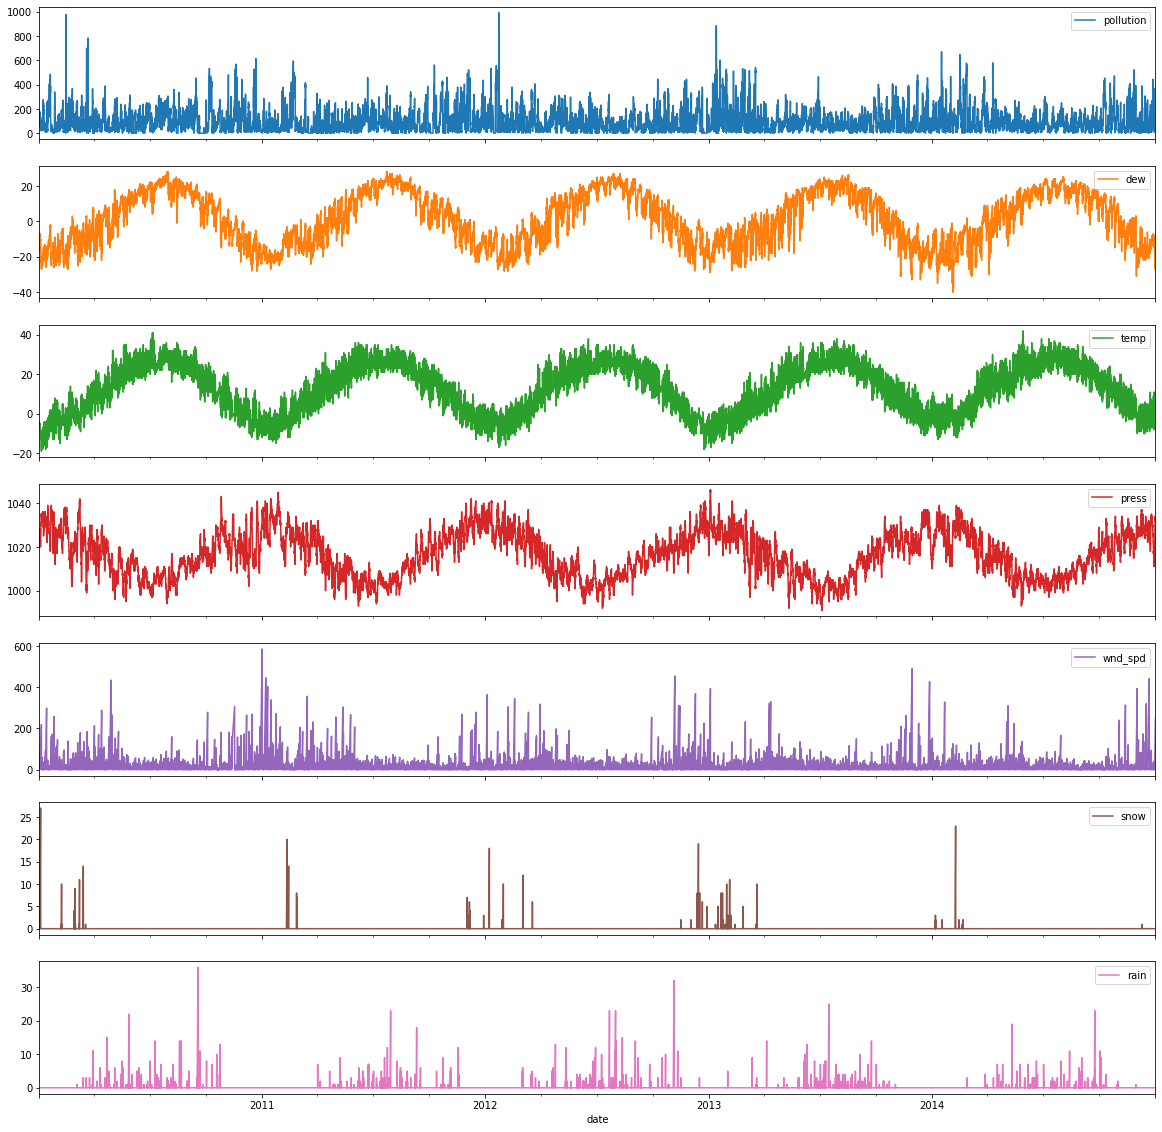

In [73]:
from matplotlib import pyplot
df.plot(subplots=True, figsize=(20,20))
pyplot.show()

### Convert the series to supervised learning problem
Helper functions in this are refered from - https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [74]:
# we need to one hot encode wind direction 
df['wnd_dir'] = df['wind_dir'].apply(lambda x : 1 if x == "SE" else 2 if x == "NE" else 3 if x =="NW" else 4)
del df['wind_dir']
df.head(5)

,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,1
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,1
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,1
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,1
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,1


In [76]:
# convert series to supervised learning
# this is like a sliding window where t-1 used as t and t-2 is used t-1 and so on
# For more detailed explanation refer - https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
values = df.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0
2,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0
3,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0
4,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0
5,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.109658,0.485294,0.213115,0.563637,0.011433,0.111111,0.0,0.0


In [77]:
# # drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.109658


### Split the Dataset into training and testing data

In [78]:
values = reframed.values
# Split the data into train and test 
n_train_hours = 365 * 24 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(test.shape,train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35039, 9) (8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


### Build and compile an RNN/LSTM model

In [79]:
# Step 1 - Build the architecture
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(1))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 256)               271360    
                                                                 
 dense_12 (Dense)            (None, 32)                8224      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_6 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 279,745
Trainable params: 279,681
Non-trainable params: 64
_______________________________________________

In [80]:
# Step 2 - Compile the model
model.compile(loss='mae', optimizer='adam')

### Training the RNN on Pollution dataset

In [81]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50


2022-08-15 11:21:50.414040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:21:50.689144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:21:50.895143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:21:52.819971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:21:52.930148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


122/122 - 6s - loss: 0.0949 - val_loss: 0.0647 - 6s/epoch - 45ms/step
Epoch 2/50
122/122 - 3s - loss: 0.0717 - val_loss: 0.0662 - 3s/epoch - 28ms/step
Epoch 3/50
122/122 - 3s - loss: 0.0640 - val_loss: 0.0584 - 3s/epoch - 28ms/step
Epoch 4/50
122/122 - 3s - loss: 0.0582 - val_loss: 0.0449 - 3s/epoch - 28ms/step
Epoch 5/50
122/122 - 3s - loss: 0.0558 - val_loss: 0.0311 - 3s/epoch - 28ms/step
Epoch 6/50
122/122 - 3s - loss: 0.0536 - val_loss: 0.0232 - 3s/epoch - 28ms/step
Epoch 7/50
122/122 - 3s - loss: 0.0533 - val_loss: 0.0319 - 3s/epoch - 28ms/step
Epoch 8/50
122/122 - 3s - loss: 0.0536 - val_loss: 0.0210 - 3s/epoch - 28ms/step
Epoch 9/50
122/122 - 3s - loss: 0.0520 - val_loss: 0.0167 - 3s/epoch - 28ms/step
Epoch 10/50
122/122 - 3s - loss: 0.0518 - val_loss: 0.0218 - 3s/epoch - 28ms/step
Epoch 11/50
122/122 - 3s - loss: 0.0518 - val_loss: 0.0184 - 3s/epoch - 28ms/step
Epoch 12/50
122/122 - 3s - loss: 0.0517 - val_loss: 0.0160 - 3s/epoch - 28ms/step
Epoch 13/50
122/122 - 3s - loss: 0.0

### Plotting Loss

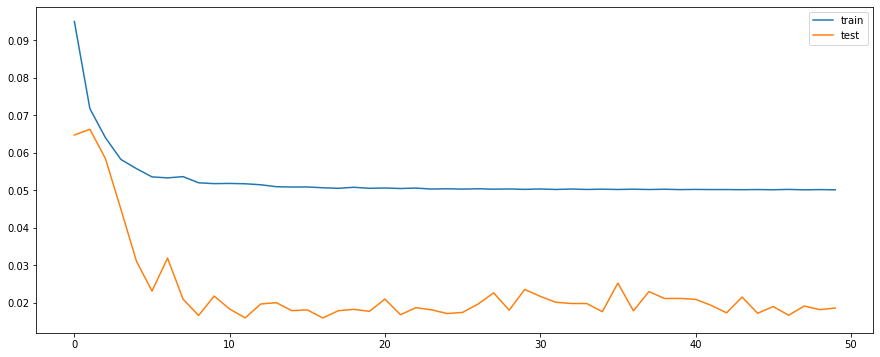

In [90]:
# plot history
plt.figure(figsize=(15,6))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Testing the model

   1/1095 [..............................] - ETA: 6:57

2022-08-15 11:30:38.782440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-15 11:30:38.902206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1095/1095 [==============================] - 5s 4ms/step
(35039, 1)
(35039,)


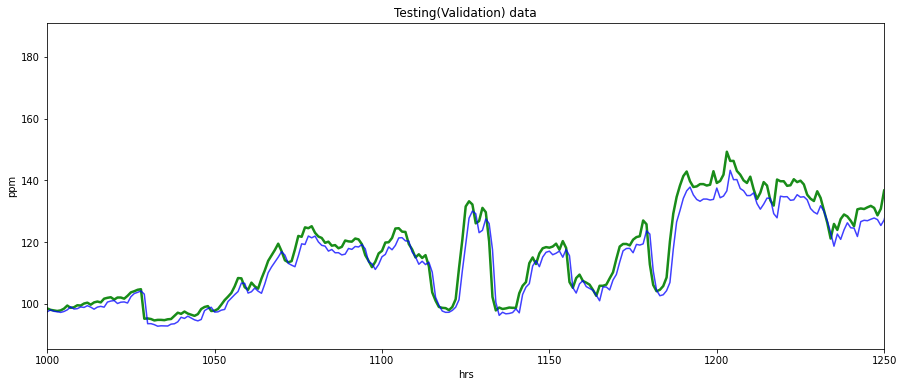

Test RMSE = 2.711199


In [89]:
y_test_actual = test[:,8]
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

poll = np.array(df["pollution"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_actual*stdop + meanop
testPredict = testPredict*stdop + meanop

from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))
print("Test RMSE ="  ,rmse)

